In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from dative_chemprop.models.DativeCGR import DativeCGR
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Arial"


torch.set_float32_matmul_precision("high")
chemprop_dir = Path.cwd()
input_path = chemprop_dir / "data" / "ML_data_with_pesudo_state.csv"
result_path = chemprop_dir / "baseline_results"
if not result_path.exists():
    os.makedirs(result_path)
dataset = pd.read_csv(input_path, index_col=0)
target_columns = ["ddG (kcal/mol)"]  # list of names of the columns containing targets
groups = dataset["reactants_couples_smiles"]
ys = dataset[target_columns].values

random_seed = 42
n_folds = 5


from sklearn.model_selection import LeaveOneGroupOut

cv = LeaveOneGroupOut()
index = 0
oos_spliting = []
for idx, (train_index, test_index) in enumerate(cv.split(dataset, groups=groups)):
    if len(test_index) > 15 and dataset.loc[test_index]["ee (%)"].median() > 30:
        index += 1
        print(f"Test set {index}: {test_index}")
        oos_spliting.append(
            pd.DataFrame(
                {
                    "group": index,
                    "data_idx": dataset.index,
                    "train or test": np.where(
                        dataset.index.isin(test_index), "test", "train"
                    ),
                }
            )
        )
        print(dataset.iloc[test_index]["reactants_couples_smiles"].unique())
        dataset.loc[test_index].to_csv(
            chemprop_dir / "data" / "OOS" / f"test_OOS_{index}.csv"
        )
        dataset.loc[train_index].to_csv(
            chemprop_dir / "data" / "OOS" / f"train_OOS_{index}.csv"
        )
d = pd.concat(oos_spliting).drop_duplicates()

Test set 1: [881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 998]
['C#CC(=O)c1ccccc1.CC(C1=CC=CC=C1C=C2C)C2=O']
Test set 2: [902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917]
['C#CC(=O)c1ccccc1.CC1=NN(C(=O)C1Cc1ccccc1)c1ccccc1']
Test set 3: [ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114]
['CC(C1=C/C(=C/c2ccccc2)/C=C(C1=O)C(C)(C)C)(C)C.O=C(N(C)C)Cc1nc2c(s1)cccc2']
Test set 4: [237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
['CCOC(=O)/C=C/C(=O)c1ccccc1.CC1=NN(C(=O)C1Cc1ccccc1)c1ccccc1']
Test set 5: [289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307]
['CCOC(=O)C(=Cc1ccccc1)C(=O)OCC.N#CCc1ccc(cc1)[N+](=O)[O-1]']
Test set 6: [717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734
 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752
 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770
 7

In [2]:
from skfp.bases import BaseFingerprintTransformer
from skfp.fingerprints import (
    AtomPairFingerprint,
    AutocorrFingerprint,
    AvalonFingerprint,
    ECFPFingerprint,
    ERGFingerprint,
    EStateFingerprint,
    GhoseCrippenFingerprint,
    KlekotaRothFingerprint,
    LaggnerFingerprint,
    LayeredFingerprint,
    LingoFingerprint,
    MACCSFingerprint,
    MAPFingerprint,
    MHFPFingerprint,
    MQNsFingerprint,
    PatternFingerprint,
    PhysiochemicalPropertiesFingerprint,
    PubChemFingerprint,
    RDKitFingerprint,
    SECFPFingerprint,
    TopologicalTorsionFingerprint,
    VSAFingerprint,
)

random_seed = 42
fp_2d_generators = {
    "AtomPair": AtomPairFingerprint(n_jobs=-1),
    "Autocorr": AutocorrFingerprint(n_jobs=-1),
    "Avalon": AvalonFingerprint(n_jobs=-1),
    "ECFP": ECFPFingerprint(n_jobs=-1),
    "ERG": ERGFingerprint(n_jobs=-1),
    "EState": EStateFingerprint(n_jobs=-1),
    "GhoseCrippen": GhoseCrippenFingerprint(n_jobs=-1),
    "KlekotaRoth": KlekotaRothFingerprint(n_jobs=-1),
    "Laggner": LaggnerFingerprint(n_jobs=-1),
    "Layered": LayeredFingerprint(n_jobs=-1),
    "Lingo": LingoFingerprint(n_jobs=-1),
    "MACCS": MACCSFingerprint(n_jobs=-1),
    "MAP": MAPFingerprint(n_jobs=-1),
    "MHFP": MHFPFingerprint(n_jobs=-1),
    "MQNs": MQNsFingerprint(n_jobs=-1),
    "Pattern": PatternFingerprint(n_jobs=-1),
    "PhysiochemicalProperties": PhysiochemicalPropertiesFingerprint(n_jobs=-1),
    "PubChem": PubChemFingerprint(n_jobs=-1),
    "RDKit": RDKitFingerprint(n_jobs=-1),
    "SECFP": SECFPFingerprint(n_jobs=-1),
    "VSA": VSAFingerprint(n_jobs=-1),
    "TopologicalTorsion": TopologicalTorsionFingerprint(n_jobs=-1),
}

from sklearn.base import RegressorMixin, is_regressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

classical_models = {
    "AdaBoost": AdaBoostRegressor(random_state=random_seed),
    "ExtraTrees": ExtraTreesRegressor(n_jobs=-1, random_state=random_seed),
    "GradientBoosting": GradientBoostingRegressor(random_state=random_seed),
    "RandomForest": RandomForestRegressor(n_jobs=-1, random_state=random_seed),
    "DecisionTree": DecisionTreeRegressor(random_state=random_seed),
    "ExtraTree": ExtraTreeRegressor(random_state=random_seed),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=random_seed),
}

from tempfile import mkdtemp
from typing import Sequence, Tuple

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import BaseCrossValidator, KFold, LeaveOneGroupOut
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.preprocessing import RobustScaler

cachedir = mkdtemp()


def build_descriptor(
    fpgen: BaseFingerprintTransformer | Sequence[BaseFingerprintTransformer],
) -> ColumnTransformer:
    if isinstance(fpgen, Sequence):
        fp_gen_pipeline = make_pipeline(
            make_union(*fpgen),
            SimpleImputer(strategy="most_frequent", keep_empty_features=True),
            RobustScaler(),
            memory=cachedir,
        )
    elif isinstance(fpgen, BaseFingerprintTransformer):
        fp_gen_pipeline = make_pipeline(
            fpgen,
            SimpleImputer(strategy="most_frequent", keep_empty_features=True),
            RobustScaler(),
            memory=cachedir,
        )
    else:
        raise ValueError(
            "fpgen must be a BaseFingerprintTransformer or a sequence of BaseFingerprintTransformer"
        )
    preprocessor = ColumnTransformer(
        transformers=[
            (subcol, fp_gen_pipeline, subcol)
            for subcol in (
                "acceptor_smiles",
                "donor_smiles",
                "additives_smiles",
                "solvents_smiles",
                "catalysts_pre_smiles",
                "ligands_smiles",
                "products_smiles",
            )
        ]
    )
    preprocessor.set_output(transform="pandas")
    return preprocessor


def build_reg_model(
    fpgen: BaseFingerprintTransformer | Sequence[BaseFingerprintTransformer],
    model: RegressorMixin,
) -> Pipeline:
    preprocessor = build_descriptor(fpgen)
    return make_pipeline(preprocessor, model)


build_reg_model(
    PubChemFingerprint(n_jobs=-1),
    RandomForestRegressor(n_jobs=-1, random_state=random_seed),
)

/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('acceptor_smiles',
                                                  Pipeline(memory='/tmp/tmpx1m4pvhx',
                                                           steps=[('pubchemfingerprint',
                                                                   PubChemFingerprint(n_jobs=-1)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(keep_empty_features=True,
                                                                                 strategy='most_frequent')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  'acceptor_smiles'),
                                                 ('donor_smiles',
                                                  Pipeline(memory...
                                                                   RobustScaler())]),
                                                  'ligands_smiles'),
                                                 ('products_smiles',
                                                  Pipeline(memory='/tmp/tmpx1m4pvhx',
                                                           steps=[('pubchemfingerprint',
                                                                   PubChemFingerprint(n_jobs=-1)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(keep_empty_features=True,
                                                                                 strategy='most_frequent')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  'products_smiles')])),
                ('randomforestregressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])

In [3]:
fp_model_pairs = [
    ("PhysiochemicalProperties", "RandomForest"),
    ("ERG", "RandomForest"),
    ("Laggner", "HistGradientBoosting"),
    ("EState", "HistGradientBoosting"),
    ("TopologicalTorsion", "HistGradientBoosting"),
    ("MHFP", "HistGradientBoosting"),
    ("MAP", "HistGradientBoosting"),
    ("Lingo", "HistGradientBoosting"),
    ("MACCS", "HistGradientBoosting"),
    ("MQNs", "HistGradientBoosting"),
    ("GhoseCrippen", "HistGradientBoosting"),
    ("KlekotaRoth", "HistGradientBoosting"),
    ("RDKit", "HistGradientBoosting"),
    ("AtomPair", "HistGradientBoosting"),
    ("Layered", "HistGradientBoosting"),
    ("SECFP", "HistGradientBoosting"),
    ("VSA", "HistGradientBoosting"),
    ("ECFP", "HistGradientBoosting"),
    ("Pattern", "HistGradientBoosting"),
    ("Autocorr", "ExtraTrees"),
    ("PubChem", "HistGradientBoosting"),
    ("Avalon", "HistGradientBoosting"),
]


X = dataset.drop("ddG (kcal/mol)", axis=1).fillna("")
y = dataset["ddG (kcal/mol)"]

result_list = []
for fp_gen_name, model_name in fp_model_pairs:
    name = f"{fp_gen_name}_with_{model_name}_ddG_OOS"
    if (result_path / f"{name}.csv").exists():
        temp_df = pd.read_csv(result_path / f"{name}.csv")
        result_list.append(temp_df)
        continue
    result_dfs = []
    desc = build_descriptor(fp_2d_generators[fp_gen_name]).fit_transform(X)
    for idx, spliting in enumerate(oos_spliting):
        m = classical_models[model_name]
        train_index = spliting.loc[spliting["train or test"] == "train"].index
        test_index = spliting.loc[spliting["train or test"] == "test"].index
        m.fit(desc.iloc[train_index], y.iloc[train_index])
        y_pred = m.predict(desc.iloc[test_index])
        result_dfs.append(
            pd.DataFrame(
                {
                    "idx": [idx] * len(test_index),
                    "data_idx": test_index,
                    "y_true": y.iloc[test_index],
                    "y_pred": y_pred,
                    "method": [f"{fp_gen_name}_{model_name}"] * len(test_index),
                }
            )
        )
    d = pd.concat(result_dfs)
    d.to_csv(result_path / f"{name}.csv")
    result_list.append(d)

In [4]:
metrics_results = []
for method, subdf in pd.concat(result_list).groupby("method"):
    temp_r2s = []
    temp_maes = []
    temp_pearsonrs = []
    for idx, subsubdf in subdf.groupby("idx"):
        temp_r2s.append(r2_score(subsubdf["y_true"], subsubdf["y_pred"]))
        temp_maes.append(mean_absolute_error(subsubdf["y_true"], subsubdf["y_pred"]))
        temp_pearsonrs.append(pearsonr(subsubdf["y_true"], subsubdf["y_pred"])[0])
    metrics_results.append(
        {
            "encoder": method.split("_")[0],
            "model": method.split("_")[1],
            "metrics": "R$^2$",
            "value": np.mean(temp_r2s),
        }
    )
    metrics_results.append(
        {
            "encoder": method.split("_")[0],
            "model": method.split("_")[1],
            "metrics": "MAE (kcal/mol)",
            "value": np.mean(temp_maes),
        }
    )
    metrics_results.append(
        {
            "encoder": method.split("_")[0],
            "model": method.split("_")[1],
            "metrics": "pearsonr",
            "value": np.mean(temp_pearsonrs),
        }
    )

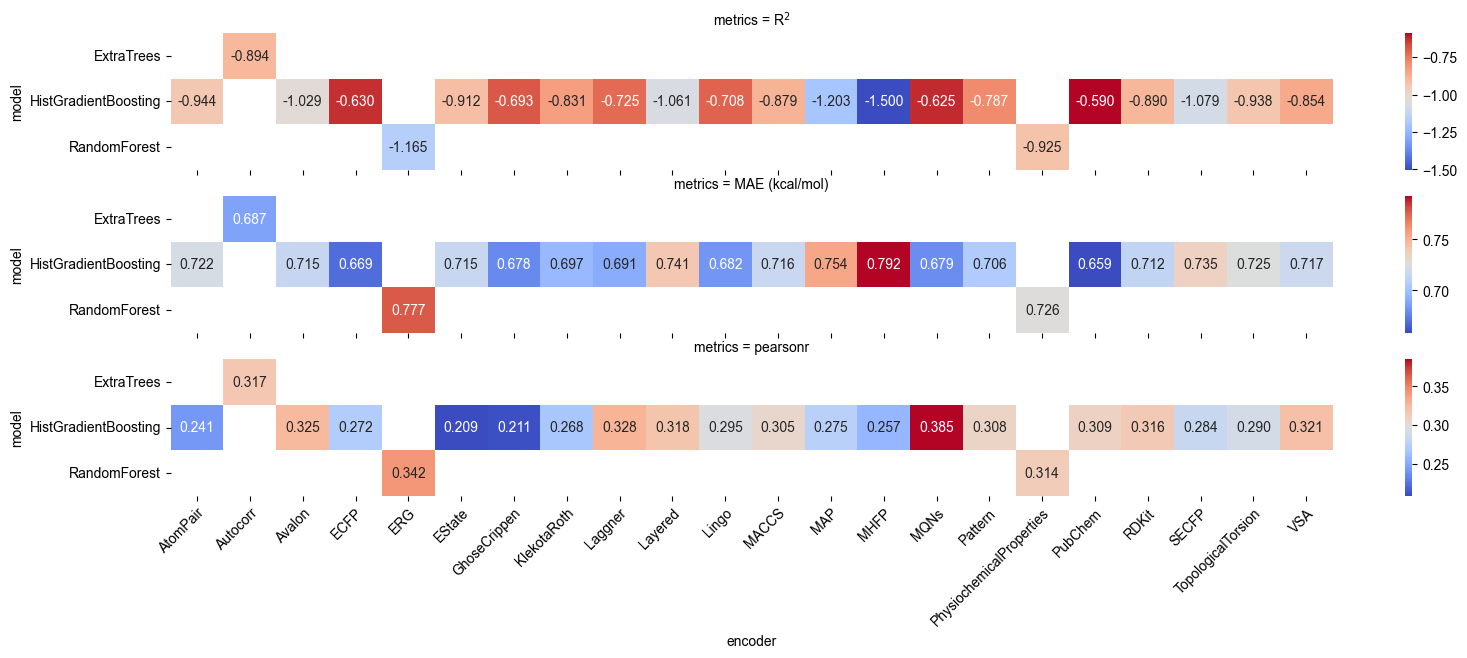

In [5]:
import seaborn as sns

g = sns.FacetGrid(
    data=pd.DataFrame(metrics_results),
    row="metrics",
    sharex=True,
)
for (i, j, k), data_ijk in g.facet_data():
    ax = g.facet_axis(i, j, k)
    sns.heatmap(
        data=data_ijk.pivot(index="model", columns="encoder", values="value"),
        annot=True,
        xticklabels=True,
        fmt=".3f",
        ax=ax,
        cmap="coolwarm",
    )
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")
        label.set_rotation_mode("anchor")
g.figure.tight_layout()
g.figure.set_size_inches(50, 6)

In [6]:
data_splits = [
    (
        pd.read_csv(
            chemprop_dir / "data" / "OOS" / f"train_OOS_{i+1}.csv", index_col=0
        ),
        pd.read_csv(chemprop_dir / "data" / "OOS" / f"test_OOS_{i+1}.csv", index_col=0),
    )
    for i in range(17)
]

rxn_smiles_columns = [
    "rxn_smiles",
]  # use different reaction SMILES to do data augmentation

target_columns = [
    "ddG (kcal/mol)",
]  # list of names of the columns containing targets
name = "CGRNN"
batch_size = 128
result_dfs = []
for idx, (train_data, test_data) in enumerate(data_splits):
    train_smis = train_data[rxn_smiles_columns].values
    train_y = train_data[target_columns].values
    test_smis = test_data[rxn_smiles_columns].values
    test_y = test_data[target_columns].values
    model = DativeCGR(
        model_name=f"1-naive_{idx}",
        seed=random_seed,
    )
    if not os.path.exists(model.model_path):
        model.fit(
            train_smis.flatten(),
            train_y.repeat(len(rxn_smiles_columns), axis=0),
            batch_size=batch_size,
            num_workers=16,
            max_epochs=600,
            val_smis=test_smis.flatten(),
            val_y=test_y.repeat(len(rxn_smiles_columns), axis=0),
        )
    pred = model.predict(test_smis.flatten(), devices=[0])[:, 0]
    ddg_pred = pred.reshape(-1, len(rxn_smiles_columns)).mean(axis=1).flatten()
    ddg_true = test_y[:, 0].flatten()
    result_dfs.append(
        pd.DataFrame(
            {
                "idx": [idx] * len(test_data.index),
                "data_idx": test_data.index,
                "y_true": ddg_true,
                "y_pred": ddg_pred,
                "method": [name] * len(test_data.index),
            }
        )
    )
d = pd.concat(result_dfs)
result_list.append(d)

Loaded model from .checkpoints/1-naive_0_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]
Loaded model from .checkpoints/1-naive_1_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.85it/s]
Loaded model from .checkpoints/1-naive_2_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.11it/s]


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Loaded model from .checkpoints/1-naive_3_reac_prod.pt.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.52it/s]
Loaded model from .checkpoints/1-naive_4_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.69it/s]


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Loaded model from .checkpoints/1-naive_5_reac_prod.pt.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.66it/s]

/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h


Loaded model from .checkpoints/1-naive_6_reac_prod.pt.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.91it/s]
Loaded model from .checkpoints/1-naive_7_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.07it/s]
Loaded model from .checkpoints/1-naive_8_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.60it/s]
Loaded model from .checkpoints/1-naive_9_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.95it/s]
Loaded model from .checkpoints/1-naive_10_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.44it/s]


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Loaded model from .checkpoints/1-naive_11_reac_prod.pt.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.20it/s]


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Loaded model from .checkpoints/1-naive_12_reac_prod.pt.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.42it/s]
Loaded model from .checkpoints/1-naive_13_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.25it/s]
Loaded model from .checkpoints/1-naive_14_reac_prod.pt.


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.33it/s]


/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h

Loaded model from .checkpoints/1-naive_15_reac_prod.pt.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.51it/s]

/home/tmj/miniforge3/envs/feng/lib/python3.11/site-packages/chemprop/models/model.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(path, map_location)
/h


Loaded model from .checkpoints/1-naive_16_reac_prod.pt.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.66it/s]


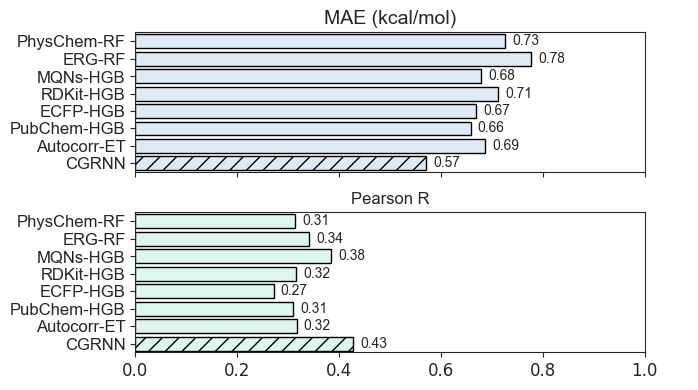

In [7]:
selected_methods = {
    "PhysiochemicalProperties_RandomForest": "PhysChem-RF",
    "ERG_RandomForest": "ERG-RF",
    "MQNs_HistGradientBoosting": "MQNs-HGB",
    "RDKit_HistGradientBoosting": "RDKit-HGB",
    "ECFP_HistGradientBoosting": "ECFP-HGB",
    "PubChem_HistGradientBoosting": "PubChem-HGB",
    "Autocorr_ExtraTrees": "Autocorr-ET",
    "CGRNN": "CGRNN",
}
results = []
for method in selected_methods:
    for df in result_list:
        if df["method"].iloc[0] != method:
            continue
        for label, subdf in df.groupby("idx"):
            results.append(
                {
                    "idx": subdf["idx"].iloc[0],
                    "method": method,
                    "metrics": "MAE",
                    "value": mean_absolute_error(subdf["y_true"], subdf["y_pred"]),
                }
            )
            results.append(
                {
                    "idx": subdf["idx"].iloc[0],
                    "method": method,
                    "metrics": "Pearson R",
                    "value": pearsonr(subdf["y_true"], subdf["y_pred"])[0],
                }
            )
with sns.axes_style("ticks"):
    g = sns.catplot(
        pd.DataFrame(results),
        y="method",
        x="value",
        row="metrics",
        kind="bar",
        sharex=True,
        errorbar=None,
        facet_kws=dict(despine=False, xlim=(0, 1)),
    )
    g.set_xlabels("")
    g.set_ylabels("")
    g.set_yticklabels(selected_methods.values(), fontfamily="Arial", fontsize=12)
    g.figure.set_size_inches(7, 4)
    for idx, ((i, j, k), data_ijk) in enumerate(g.facet_data()):
        ax = g.facet_axis(i, j, k)
        if idx == 0:
            for bar in ax.containers[0]:
                bar.set_edgecolor("black")
                bar.set_facecolor(color="#DEEBF7")
            else:
                bar.set_hatch("//")
            ax.set_title("MAE (kcal/mol)", fontsize=14, fontfamily="Arial")
        if idx == 1:
            for bar in ax.containers[0]:
                bar.set_edgecolor("black")
                bar.set_facecolor(color="#DEF7EC")
            else:
                bar.set_hatch("//")
            ax.set_title("Pearson R", fontsize=12, fontfamily="Arial")
    for idx, ((i, j, k), data_ijk) in enumerate(g.facet_data()):
        ax = g.facet_axis(i, j, k)
        for i, label in enumerate(ax.get_xticklabels()):
            label.set_fontsize(12)
        ax.bar_label(
            container=ax.containers[0],
            fmt="%.2f",
            padding=5,
            fontfamily="Arial",
            fontsize=10,
        )
g.tight_layout()
g.figure.savefig("img/LORO-Validation.png", dpi=300)

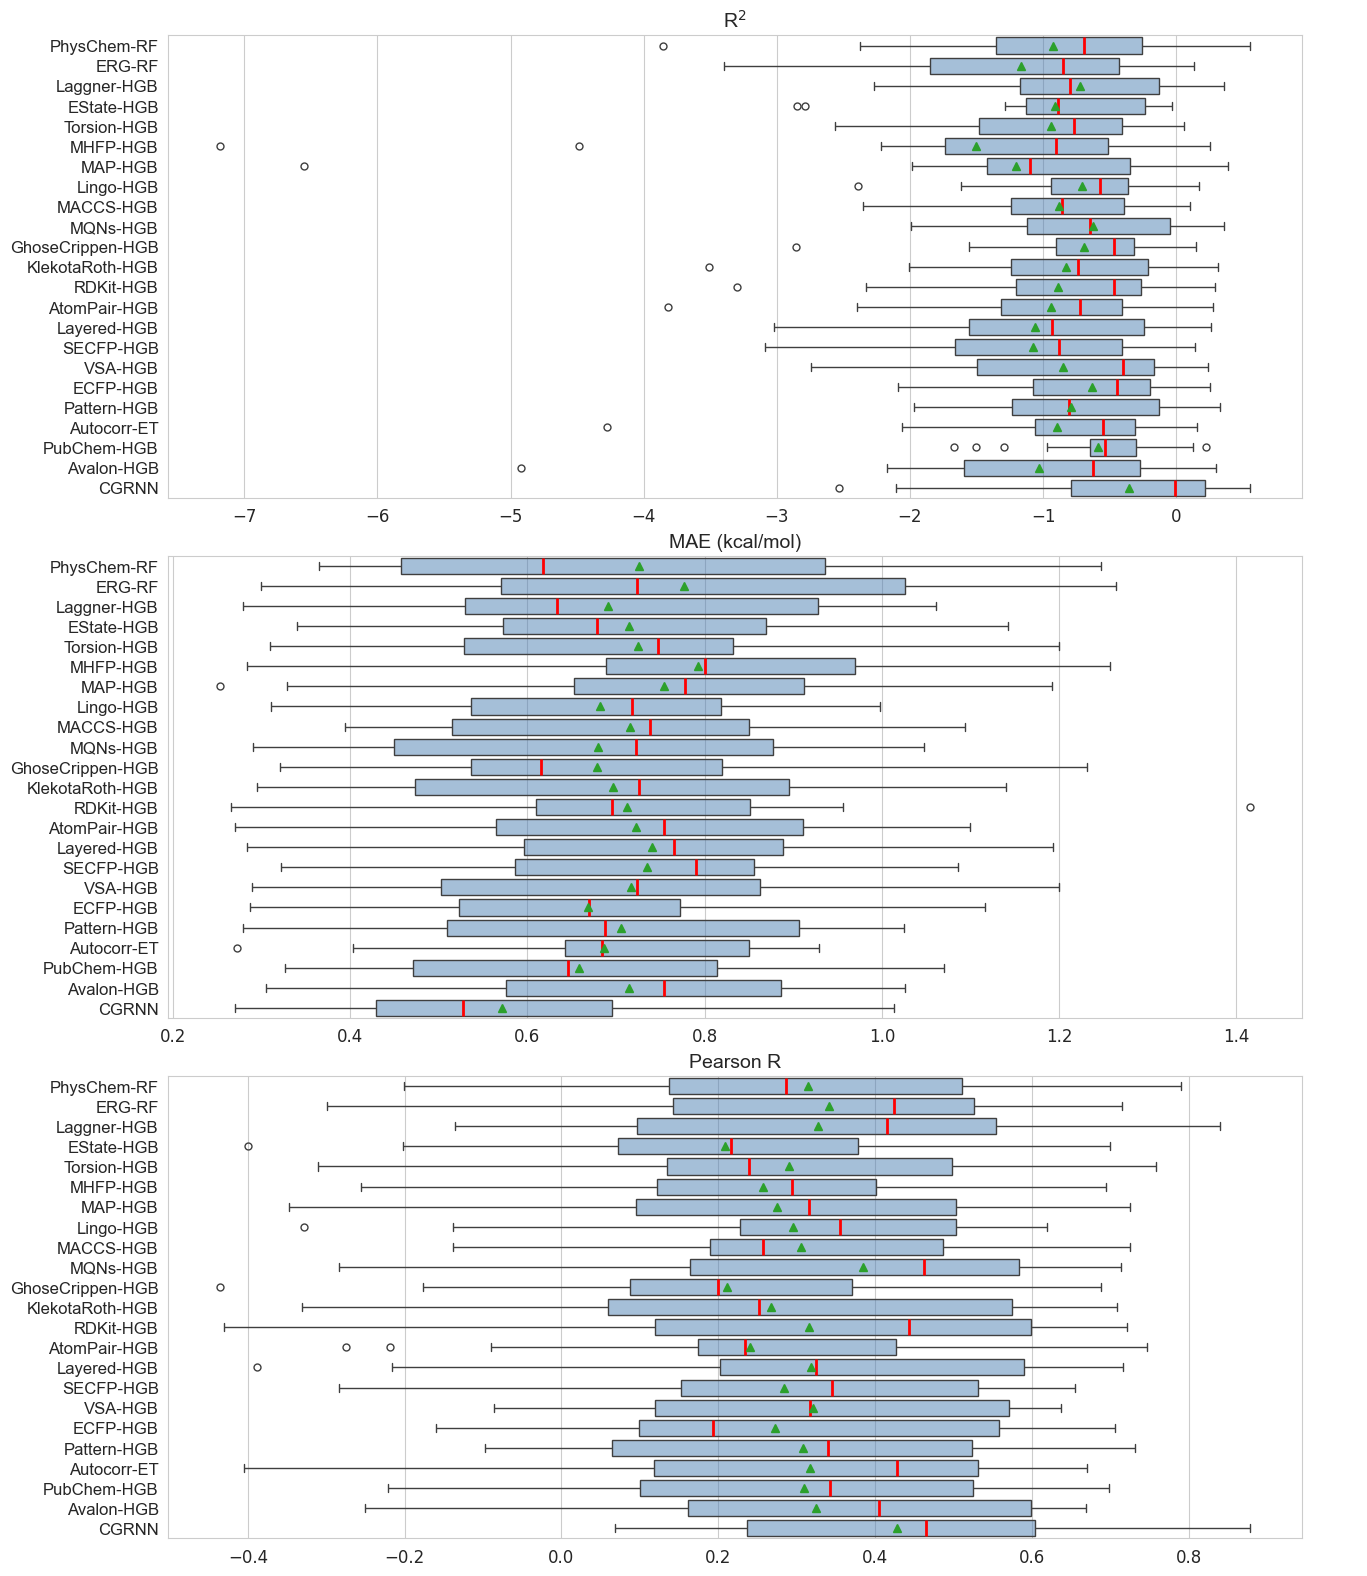

In [8]:
import seaborn as sns

selected_methods = {
    "PhysiochemicalProperties_RandomForest": "PhysChem-RF",
    "ERG_RandomForest": "ERG-RF",
    "Laggner_HistGradientBoosting": "Laggner-HGB",
    "EState_HistGradientBoosting": "EState-HGB",
    "TopologicalTorsion_HistGradientBoosting": "Torsion-HGB",
    "MHFP_HistGradientBoosting": "MHFP-HGB",
    "MAP_HistGradientBoosting": "MAP-HGB",
    "Lingo_HistGradientBoosting": "Lingo-HGB",
    "MACCS_HistGradientBoosting": "MACCS-HGB",
    "MQNs_HistGradientBoosting": "MQNs-HGB",
    "GhoseCrippen_HistGradientBoosting": "GhoseCrippen-HGB",
    "KlekotaRoth_HistGradientBoosting": "KlekotaRoth-HGB",
    "RDKit_HistGradientBoosting": "RDKit-HGB",
    "AtomPair_HistGradientBoosting": "AtomPair-HGB",
    "Layered_HistGradientBoosting": "Layered-HGB",
    "SECFP_HistGradientBoosting": "SECFP-HGB",
    "VSA_HistGradientBoosting": "VSA-HGB",
    "ECFP_HistGradientBoosting": "ECFP-HGB",
    "Pattern_HistGradientBoosting": "Pattern-HGB",
    "Autocorr_ExtraTrees": "Autocorr-ET",
    "PubChem_HistGradientBoosting": "PubChem-HGB",
    "Avalon_HistGradientBoosting": "Avalon-HGB",
    "CGRNN": "CGRNN",
}
results = []
for method in selected_methods:
    for df in result_list:
        if df["method"].iloc[0] != method:
            continue
        for label, subdf in df.groupby("idx"):
            results.append(
                {
                    "idx": subdf["idx"].iloc[0],
                    "method": method,
                    "metrics": "R$^2$",
                    "value": r2_score(subdf["y_true"], subdf["y_pred"]),
                }
            )
            results.append(
                {
                    "idx": subdf["idx"].iloc[0],
                    "method": method,
                    "metrics": "MAE",
                    "value": mean_absolute_error(subdf["y_true"], subdf["y_pred"]),
                }
            )
            results.append(
                {
                    "idx": subdf["idx"].iloc[0],
                    "method": method,
                    "metrics": "Pearson R",
                    "value": pearsonr(subdf["y_true"], subdf["y_pred"])[0],
                }
            )
with sns.axes_style("whitegrid"):
    g = sns.catplot(
        pd.DataFrame(results),
        y="method",
        x="value",
        row="metrics",
        kind="box",
        sharex=False,
        boxprops={"facecolor": (0.3, 0.5, 0.7, 0.5)},
        medianprops={"color": "r", "linewidth": 2},
        facet_kws=dict(despine=False),
        showmeans=True,
    )
    g.figure.set_size_inches(15, 16)
    g.tight_layout()
    g.set_xlabels("")
    g.set_ylabels("")
    g.set_yticklabels(selected_methods.values(), fontfamily="Arial", fontsize=12)
    for idx, ((i, j, k), data_ijk) in enumerate(g.facet_data()):
        ax = g.facet_axis(i, j, k)
        if idx == 0:
            ax.set_title("R$^2$", fontsize=14, fontfamily="Arial")
        if idx == 1:
            ax.set_title("MAE (kcal/mol)", fontsize=14, fontfamily="Arial")
        if idx == 2:
            ax.set_title("Pearson R", fontsize=14, fontfamily="Arial")
    for idx, ((i, j, k), data_ijk) in enumerate(g.facet_data()):
        ax = g.facet_axis(i, j, k)
        for i, label in enumerate(ax.get_xticklabels()):
            label.set_fontsize(12)
#